# Baseline model (logistic regression)

In [51]:
import pandas as pd
import numpy as np

df = pd.read_csv("df_to_train.csv")

#Now for my binary prediction I am going to exclude the first month of every customer, as they have a lot nan from the "trend"-features.
df.sort_values(["Customer_number", "FactDt"], inplace=True)
df_bi = df.loc[df.groupby('Customer_number').cumcount() > 0].copy()


#I am also going to exclude the last month for every customer that has BI-Label = 0, as these are the one I am the end want to calcualate an unbias probability to be first time investors.
df_bi = df_bi[~((df_bi['BI_Label'] == 0) & (df_bi.groupby('Customer_number')['FactDt'].transform('max') == df_bi['FactDt']))]

print('Rows before:', len(df))
print('Rows after :', len(df_bi))

Rows before: 70533
Rows after : 58184


In [52]:
#locate nan variables in the dataset
nan_cols = df_bi.columns[df_bi.isna().any()].tolist()
print("Columns with NaN values:", nan_cols)



Columns with NaN values: []


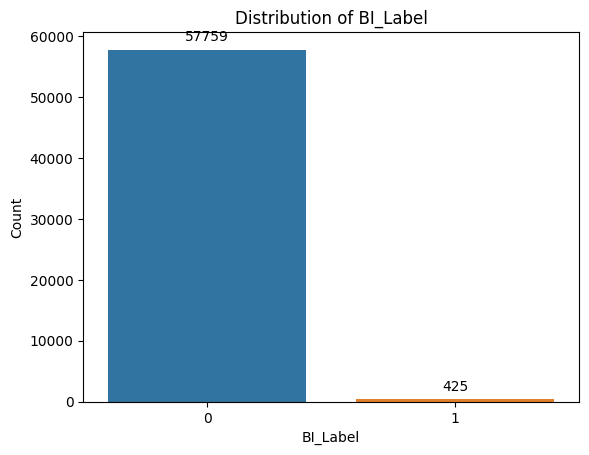

In [53]:
# plot the distribution of the target variable with actual counts on bars
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x='BI_Label', data=df_bi)
plt.title('Distribution of BI_Label')
plt.xlabel('BI_Label')
plt.ylabel('Count')

# add count labels
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(
        f'{height}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        xytext=(0, 4),
        textcoords='offset points'
    )

plt.show()

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Column groups
# -----------------------------
binary_cols = [
    'CustGenderCd_M', 'CustGenderCd_N',
    'IsGeneralMarketingAllowed', 'IsMarketingForEmailAllowed',
    'IsMarketingForSmsAllowed', 'IsMarketingForLetterAllowed',
    'IsMarketingForPhoneAllowed', 'IsMarketingForEbankAllowed',
    'HomeLoan_taken_4m', 'CAR_LOANS_taken_4m'
]

minmax_cols = [
    'fam_members_diff_1m',
    'fam_members_change_dir',
    'fam_members_months_since_change',
    'fam_members_adult', 'fam_members',
    'HomeLoan_months_since_taken',
    'CAR_LOANS_months_since_taken'
]

financial_cols = [
    'Business_Volume', 'Gross_wealth', 'Net_Wealth', 'House_free_Equity',
    'Financial_Assets', 'RealEstateValue', 'HomeLoan', 'CAR_LOANS',
    'All_Loans', 'BOAT_LOANS', 'Other_loans',
    'AvgDepositsValueDKK', 'AvgPensionValueDKK', 'AvgHomeFinanceValueDKK',
    'AvgOtherLoansValueDKK', 'AvgInvestmentsValueDKK',
    'Deposits_Cards_lowest', 'Deposits_ordinary_lowest'
]

features = [
    'Business_Volume', 'Gross_wealth', 'Net_Wealth', 'House_free_Equity',
    'Financial_Assets', 'RealEstateValue', 'HomeLoan', 'CAR_LOANS',
    'All_Loans', 'BOAT_LOANS', 'Other_loans', 'CustAgeInYears',
    'CustGenderCd_M', 'CustGenderCd_N', 'fam_members_adult', 'fam_members',
    'CustMobileLogOnPerMth', 'CustNetBankLogOnPerMth',
    'IsGeneralMarketingAllowed', 'IsMarketingForEmailAllowed',
    'IsMarketingForSmsAllowed', 'IsMarketingForLetterAllowed',
    'IsMarketingForPhoneAllowed', 'IsMarketingForEbankAllowed',
    'AvgDepositsValueDKK', 'AvgPensionValueDKK', 'AvgHomeFinanceValueDKK',
    'AvgOtherLoansValueDKK', 'AvgInvestmentsValueDKK',
    'Deposits_Cards_lowest', 'Deposits_ordinary_lowest',
    'Creditcard_overdraft_lowest', 'anc_y', 'Business_Volume_log_diff_1m_pct',
    'Business_Volume_trend_4m', 'Net_Wealth_log_diff_1m_pct',
    'Net_Wealth_trend_4m', 'Financial_Assets_log_diff_1m_pct',
    'Financial_Assets_trend_4m', 'CustMobileLogOnPerMth_diff_1m',
    'CustMobileLogOnPerMth_diff_4m_mean', 'CustNetBankLogOnPerMth_diff_1m',
    'CustNetBankLogOnPerMth_diff_4m_mean', 'fam_members_diff_1m',
    'fam_members_change_dir', 'fam_members_months_since_change',
    'HomeLoan_taken_4m', 'HomeLoan_months_since_taken',
    'CAR_LOANS_taken_4m', 'CAR_LOANS_months_since_taken'
]

def signed_log1p(s):
    s = pd.to_numeric(s, errors='coerce')
    return np.sign(s) * np.log1p(np.abs(s))

print('Setup ready. Financial vars:', len(financial_cols), '| Total candidate features:', len(features))

Setup ready. Financial vars: 18 | Total candidate features: 50


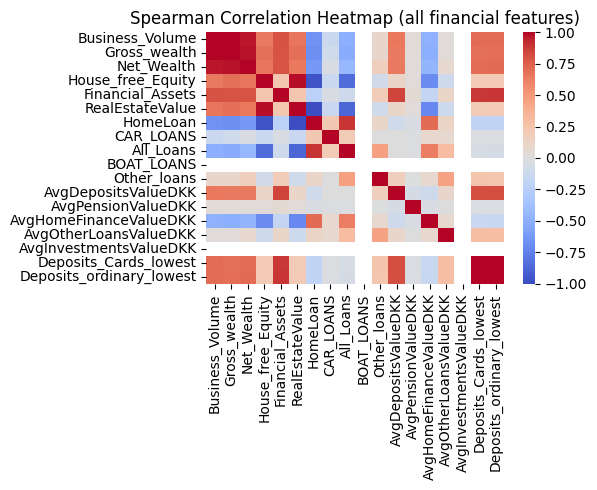

In [ ]:
# 1) Heatmap of all model variables (before feature reduction)
all_model_cols = [c for c in features if c in df_bi.columns]
tmp_all = df_bi[all_model_cols].copy()

# numeric + safe values
for c in all_model_cols:
    tmp_all[c] = pd.to_numeric(tmp_all[c], errors='coerce')
tmp_all = tmp_all.replace([np.inf, -np.inf], np.nan)

corr_all = tmp_all.corr(method='spearman')

plt.figure(figsize=(16, 13))
sns.heatmap(corr_all, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Spearman Correlation Heatmap (all model variables)')
plt.tight_layout()
plt.show()

Feature importance for predicting label 1 (positive class):


,feature,coef,odds_ratio,abs_coef,effect_on_label_1
36,IsMarketingForEmailAllowed,"1,10","3,00","1,10",increases
1,House_free_Equity,"0,56","1,76","0,56",increases
29,fam_members_adult,"0,43","1,54","0,43",increases
37,IsMarketingForSmsAllowed,"0,33","1,39","0,33",increases
10,AvgOtherLoansValueDKK,"0,30","1,35","0,30",increases
2,Financial_Assets,"0,28","1,33","0,28",increases
28,fam_members_months_since_change,"0,13","1,14","0,13",increases
13,CustNetBankLogOnPerMth,"0,12","1,13","0,12",increases
0,Business_Volume,"0,11","1,11","0,11",increases
6,Other_loans,"0,10","1,10","0,10",increases


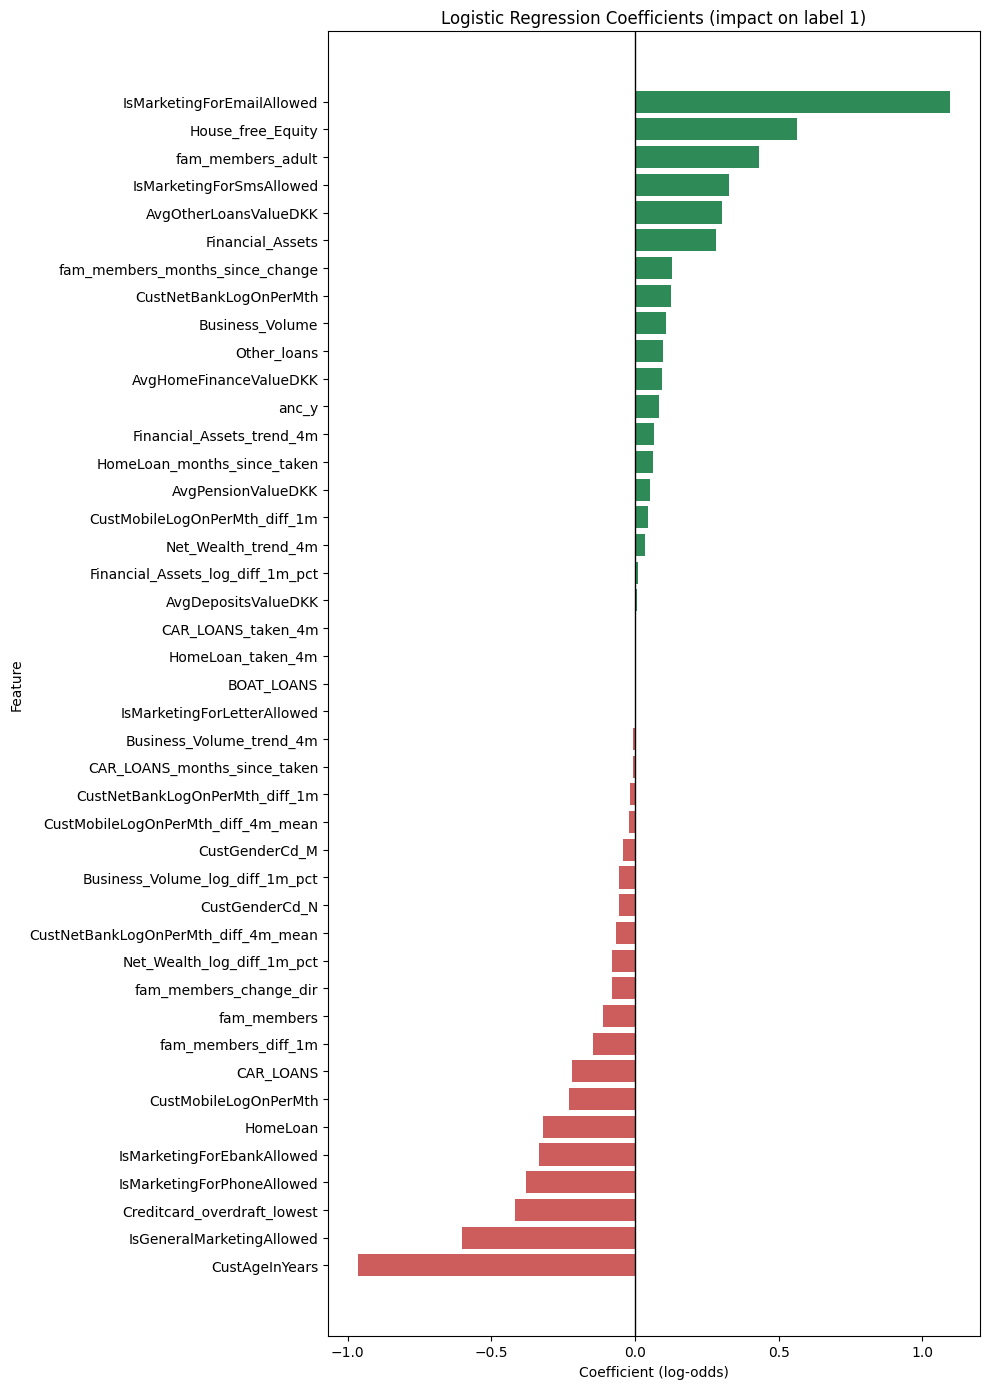

In [ ]:
# 2) Fit on full feature set and extract feature importance (before reduction)
X_full = df_bi[[c for c in features if c in df_bi.columns]].copy()
X_full = X_full.replace([np.inf, -np.inf], np.nan)
y_full = df_bi['BI_Label'].astype(int).values

effective_binary_full = [c for c in binary_cols if c in X_full.columns]
effective_minmax_full = [c for c in minmax_cols if c in X_full.columns]
effective_financial_full = [c for c in financial_cols if c in X_full.columns]

all_specified_full = set(effective_binary_full) | set(effective_minmax_full) | set(effective_financial_full)
effective_standard_full = [c for c in X_full.columns if c not in all_specified_full]

def signed_log1p_np(arr):
    return np.sign(arr) * np.log1p(np.abs(arr))

signed_log_full = FunctionTransformer(signed_log1p_np, feature_names_out='one-to-one')

preprocess_full = ColumnTransformer(
    transformers=[
        ('fin', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('signed_log', signed_log_full),
            ('scaler', StandardScaler())
        ]), effective_financial_full),
        ('std', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), effective_standard_full),
        ('mm', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), effective_minmax_full),
        ('bin', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ]), effective_binary_full),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

model_full = LogisticRegression(max_iter=3000, class_weight='balanced', solver='liblinear')
pipe_full = Pipeline([('prep', preprocess_full), ('model', model_full)])
pipe_full.fit(X_full, y_full)

feature_names_full = pipe_full.named_steps['prep'].get_feature_names_out()
coefs_full = pipe_full.named_steps['model'].coef_[0]

importance_df = pd.DataFrame({
    'feature': feature_names_full,
    'coef': coefs_full,
    'odds_ratio': np.exp(coefs_full),
    'abs_coef': np.abs(coefs_full),
    'effect_on_label_1': np.where(coefs_full >= 0, 'increases', 'decreases')
}).sort_values('abs_coef', ascending=False)

print('Feature importance from full feature set:')
display(importance_df.head(40))

plot_df = importance_df.sort_values('coef', ascending=True).tail(30)
colors = np.where(plot_df['coef'] >= 0, 'seagreen', 'indianred')

plt.figure(figsize=(10, 12))
plt.barh(plot_df['feature'], plot_df['coef'], color=colors)
plt.axvline(0, color='black', linewidth=1)
plt.title('Top Logistic Coefficients (full feature set)')
plt.xlabel('Coefficient (log-odds)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [97]:
# 3) Keep reduced financial set, then build final feature list
old_feature_count = len(features)

features = [
    f for f in features
    if (f not in financial_cols) or (f in reduced_financial_cols)
]

# remove duplicates and columns not present in df_bi
features = list(dict.fromkeys([f for f in features if f in df_bi.columns]))

removed_count = old_feature_count - len(features)
print('Final feature count:', len(features))
print('Financial columns kept:', len(reduced_financial_cols))
print('Columns removed from original candidate list:', removed_count)

Final feature count: 43
Financial columns kept: 11
Columns removed from original candidate list: 7


In [98]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# X/y/groups from df_bi (based on current feature list)
X = df_bi[features].copy()
X = X.replace([np.inf, -np.inf], np.nan)
y = df_bi["BI_Label"].astype(int).values
groups = df_bi["Customer_number"].values

# Keep only columns that are present in current X and current features
effective_binary = [c for c in binary_cols if c in X.columns]
effective_minmax = [c for c in minmax_cols if c in X.columns]
effective_financial = [c for c in financial_cols if c in X.columns]

all_specified = set(effective_binary) | set(effective_minmax) | set(effective_financial)
effective_standard = [c for c in X.columns if c not in all_specified]

def signed_log1p_np(arr):
    return np.sign(arr) * np.log1p(np.abs(arr))

signed_log = FunctionTransformer(signed_log1p_np, feature_names_out="one-to-one")

preprocess = ColumnTransformer(
    transformers=[
        ("fin", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("signed_log", signed_log),
            ("scaler", StandardScaler())
        ]), effective_financial),
        ("std", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), effective_standard),
        ("mm", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler())
        ]), effective_minmax),
        ("bin", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent"))
        ]), effective_binary),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

log_reg = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    solver="liblinear"
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", log_reg)
])

# Customer-level stratification label (1 if customer ever has BI_Label=1)
cust_y = df_bi.groupby("Customer_number")["BI_Label"].max()
y_strat = df_bi["Customer_number"].map(cust_y).astype(int).values

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

fold_pr, fold_roc = [], []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y_strat, groups=groups), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    pipe.fit(X_tr, y_tr)
    p_va = pipe.predict_proba(X_va)[:, 1]

    pr_auc = average_precision_score(y_va, p_va)
    roc_auc = roc_auc_score(y_va, p_va)

    fold_pr.append(pr_auc)
    fold_roc.append(roc_auc)

    print(f"Fold {fold}: PR-AUC={pr_auc:.4f} | ROC-AUC={roc_auc:.4f} | "
          f"Positives in val={y_va.sum()} / {len(y_va)}")

print("\nMean PR-AUC:", np.mean(fold_pr))
print("Std  PR-AUC:", np.std(fold_pr))
print("Mean ROC-AUC:", np.mean(fold_roc))
print("Std  ROC-AUC:", np.std(fold_roc))

Fold 1: PR-AUC=0.0150 | ROC-AUC=0.7044 | Positives in val=98 / 11605
Fold 2: PR-AUC=0.0318 | ROC-AUC=0.7681 | Positives in val=112 / 11612
Fold 3: PR-AUC=0.0158 | ROC-AUC=0.7157 | Positives in val=81 / 11629
Fold 4: PR-AUC=0.0057 | ROC-AUC=0.5604 | Positives in val=61 / 11677
Fold 5: PR-AUC=0.0244 | ROC-AUC=0.6927 | Positives in val=73 / 11661

Mean PR-AUC: 0.01855913497377689
Std  PR-AUC: 0.008891010448157313
Mean ROC-AUC: 0.6882473684899253
Std  ROC-AUC: 0.06894825782043788


Feature importance for predicting label 1 (positive class):


,feature,coef,odds_ratio,abs_coef,effect_on_label_1
36,IsMarketingForEmailAllowed,"1,10","3,00","1,10",increases
1,House_free_Equity,"0,56","1,76","0,56",increases
29,fam_members_adult,"0,43","1,54","0,43",increases
37,IsMarketingForSmsAllowed,"0,33","1,39","0,33",increases
10,AvgOtherLoansValueDKK,"0,30","1,35","0,30",increases
2,Financial_Assets,"0,28","1,33","0,28",increases
28,fam_members_months_since_change,"0,13","1,14","0,13",increases
13,CustNetBankLogOnPerMth,"0,12","1,13","0,12",increases
0,Business_Volume,"0,11","1,11","0,11",increases
6,Other_loans,"0,10","1,10","0,10",increases


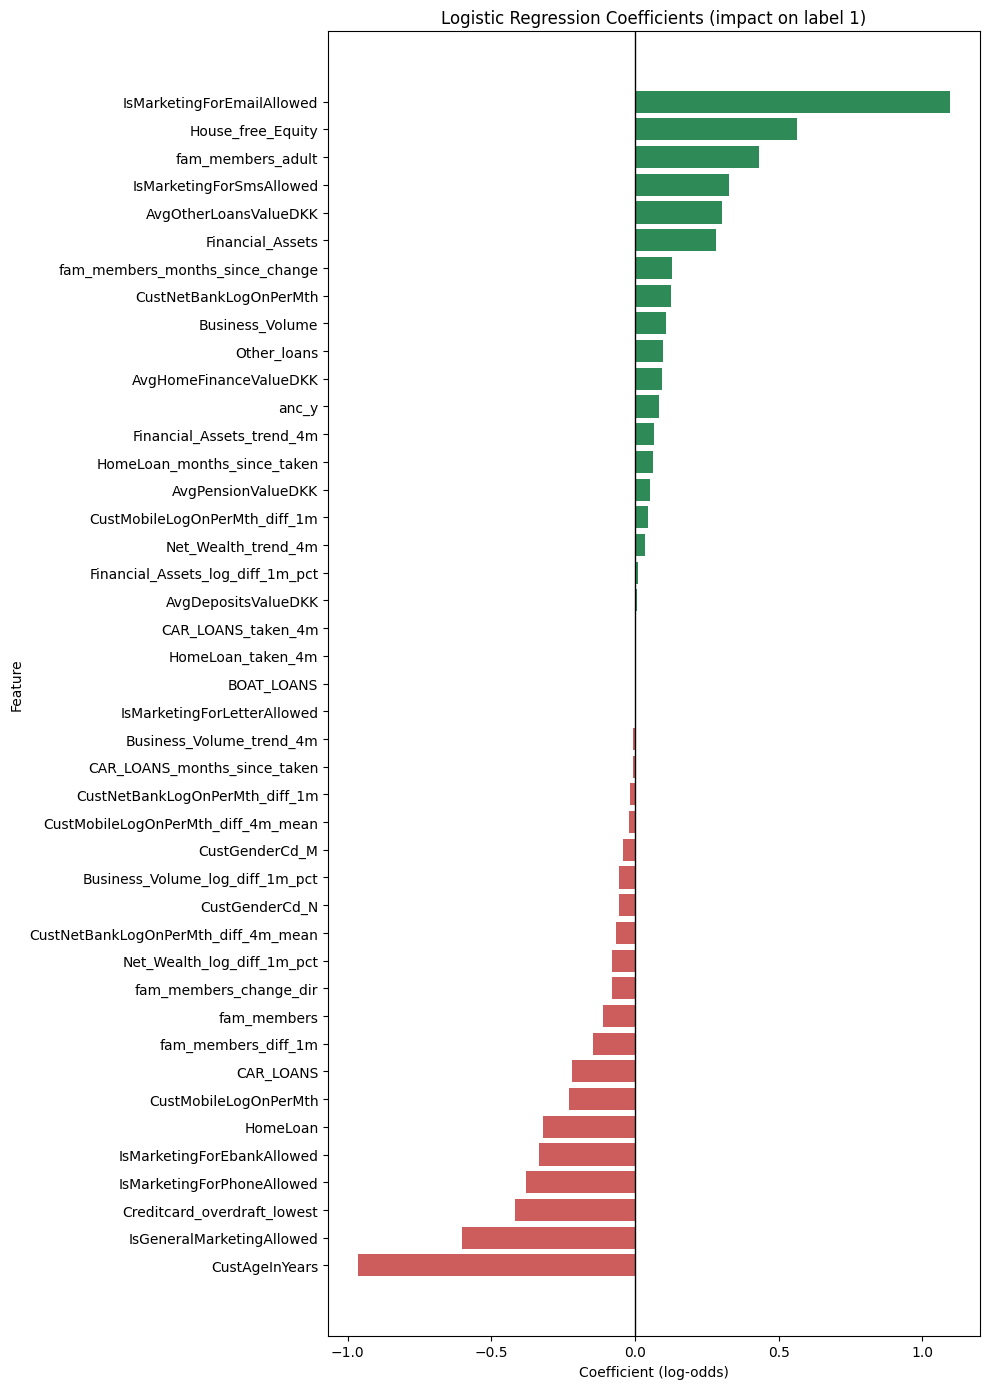

In [ ]:
#spli

In [ ]:
#start by just fitting a logistic regression model to see how my features affect probability of being a first time investor. 


In [38]:
df_bi

,Customer_number,FactDt,BI_Label,event_observed,TTE,Business_Volume,Gross_wealth,Net_Wealth,House_free_Equity,Financial_Assets,RealEstateValue,HomeLoan,CAR_LOANS,All_Loans,BOAT_LOANS,Other_loans,CustAgeInYears,CustGenderCd_M,CustGenderCd_N,fam_members_adult,fam_members,CustMobileLogOnPerMth,CustNetBankLogOnPerMth,IsGeneralMarketingAllowed,IsMarketingForEmailAllowed,IsMarketingForSmsAllowed,IsMarketingForLetterAllowed,IsMarketingForPhoneAllowed,IsMarketingForEbankAllowed,AvgDepositsValueDKK,AvgPensionValueDKK,AvgHomeFinanceValueDKK,AvgOtherLoansValueDKK,AvgInvestmentsValueDKK,Deposits_Cards_lowest,Deposits_ordinary_lowest,Creditcard_overdraft_lowest,anc_y,Business_Volume_change_pct,Business_Volume_trend_4m,Net_Wealth_change_pct,Net_Wealth_trend_4m,Financial_Assets_change_pct,Financial_Assets_trend_4m,CustMobileLogOnPerMth_diff_1m,CustMobileLogOnPerMth_diff_4m_mean,CustNetBankLogOnPerMth_diff_1m,CustNetBankLogOnPerMth_diff_4m_mean,fam_members_diff_1m,fam_members_change_dir,fam_members_months_since_change,HomeLoan_taken_4m,HomeLoan_months_since_taken,CAR_LOANS_taken_4m,CAR_LOANS_months_since_taken
1,000022D8D733FA51200BF5F45C37AED2,2022-02-28,0,0,"12,00","13,45","13,45","13,45","0,00","13,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00",0,0,2,2,0,0,1,0,0,0,0,0,"13,45","0,00","0,00","0,00",0,"13,45","13,45","0,00","1,34","0,00","-0,00","0,00","-0,00","0,00","-0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
2,000022D8D733FA51200BF5F45C37AED2,2022-03-31,0,0,"11,00","13,45","13,45","13,45","0,00","13,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00",0,0,2,2,0,0,1,0,0,0,0,0,"13,45","0,00","0,00","0,00",0,"13,45","13,45","0,00","1,43","0,00","-0,00","0,00","-0,00","0,00","-0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
3,000022D8D733FA51200BF5F45C37AED2,2022-04-30,0,0,"10,00","818,45","818,45","818,45","0,00","818,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00",0,0,2,2,0,0,1,0,0,0,0,0,"630,62","0,00","0,00","0,00",0,"13,45","13,45","0,00","1,51","5.985,13","235,81","5.985,13","235,81","5.985,13","235,81","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
4,000022D8D733FA51200BF5F45C37AED2,2022-05-31,0,0,"9,00","818,45","818,45","818,45","0,00","818,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00",0,0,2,2,0,0,1,0,0,0,0,0,"818,45","0,00","0,00","0,00",0,"818,45","818,45","0,00","1,59","0,00","402,88","0,00","402,88","0,00","402,88","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
5,000022D8D733FA51200BF5F45C37AED2,2022-06-30,0,0,"8,00","818,45","818,45","818,45","0,00","818,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00",0,0,2,2,0,0,1,0,0,0,0,0,"818,45","0,00","0,00","0,00",0,"818,45","818,45","0,00","1,68","0,00","235,81","0,00","235,81","0,00","235,81","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70527,0174CFCBED87171B4F6A651734F836E4,2022-06-30,0,0,"8,00","1.920.724,30","4.364.060,46","3.007.396,62","2.443.336,16","564.060,46","3.800.000,00","-1.356.663,84","0,00","-1.356.663,84","0,00","0,00","61,00",1,0,2,2,0,1,1,0,0,0,0,0,"551.740,85","0,00","-1.475.695,99","0,00",0,"535.524,59","535.524,59","0,00","25,43","-1,54","-1,04","3,18","2,01","-1,09","1,36","0,00","0,00","-4,00","-0,25","0,00","0,00","0,00","-1.356.663,84","0,00","0,00","0,00"
70528,0174CFCBED87171B4F6A651734F836E4,2022-07-31,0,0,"7,00","1.957.353,73","4.364.667,34","2.971.980,95","2.407.313,61","564.667,34","3.800.000,00","-1.392.686,39","0,00","-1.392.686,39","0,00","0,00","61,00",1,0,2,2,0,1,1,0,0,0,0,0,"543.163,49","0,00","-1.467.887,13","0,00",0,"526.440,22","526.440,22","0,00","25,51","1,91","0,04","-1,18","1,20","0,11","0,51","0,00","0,00","0,00","-0,25","0,00","0,0

In [30]:
df.loc[df['Customer_number']=='00007ED83AE63F4C495F7ABA8089EBBD', ['Customer_number', 'FactDt', 'Business_Volume','Business_Volume_change_pct']]

,Customer_number,FactDt,Business_Volume,Business_Volume_change_pct
50,00007ED83AE63F4C495F7ABA8089EBBD,2022-03-31,"0,00",NaN
51,00007ED83AE63F4C495F7ABA8089EBBD,2022-04-30,"0,00",NaN


In [33]:
df.loc[df['Customer_number']=='00E7955858E34C6A92014DDC16F16CED']

,Customer_number,FactDt,BI_Label,event_observed,TTE,Business_Volume,Gross_wealth,Net_Wealth,House_free_Equity,Financial_Assets,RealEstateValue,HomeLoan,CAR_LOANS,All_Loans,BOAT_LOANS,Other_loans,CustAgeInYears,CustGenderCd_M,CustGenderCd_N,fam_members_adult,fam_members,CustMobileLogOnPerMth,CustNetBankLogOnPerMth,IsGeneralMarketingAllowed,IsMarketingForEmailAllowed,IsMarketingForSmsAllowed,IsMarketingForLetterAllowed,IsMarketingForPhoneAllowed,IsMarketingForEbankAllowed,AvgDepositsValueDKK,AvgPensionValueDKK,AvgHomeFinanceValueDKK,AvgOtherLoansValueDKK,AvgInvestmentsValueDKK,Deposits_Cards_lowest,Deposits_ordinary_lowest,Creditcard_overdraft_lowest,anc_y,Business_Volume_change_pct,Business_Volume_trend_4m,Net_Wealth_change_pct,Net_Wealth_trend_4m,Financial_Assets_change_pct,Financial_Assets_trend_4m,CustMobileLogOnPerMth_diff_1m,CustMobileLogOnPerMth_diff_4m_mean,CustNetBankLogOnPerMth_diff_1m,CustNetBankLogOnPerMth_diff_4m_mean,fam_members_diff_1m,fam_members_change_dir,fam_members_months_since_change,HomeLoan_taken_4m,HomeLoan_months_since_taken,CAR_LOANS_taken_4m,CAR_LOANS_months_since_taken
43320,00E7955858E34C6A92014DDC16F16CED,2022-01-31,1,1,"1,00","468.855,55","1.349.034,79","896.262,54","880.179,24","16.083,30","1.332.951,49","-452.772,25","0,00","-452.772,25","0,00","0,00","34,00",1,0,2,4,39,1,1,1,1,0,1,1,"2.479,42","0,00","-455.675,48","0,00",0,"-4.976,51","-4.976,51","0,00","25,83",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0,00","-452.772,25","0,00","0,00","0,00"
43321,00E7955858E34C6A92014DDC16F16CED,2022-03-31,1,1,NaN,"472.960,96","1.354.396,44","902.880,43","881.435,48","21.444,95","1.332.951,49","-451.516,01","0,00","-451.516,01","0,00","0,00","34,00",1,0,2,4,69,3,1,1,1,0,1,1,"2.336,37","0,00","-449.675,48","0,00",534,"-4.113,11","-4.113,11","0,00","26,00","0,88","0,88","0,74","0,74","33,34","33,33","30,00","30,00","2,00","2,00","0,00","0,00","0,00","-451.516,01","0,00","0,00","0,00"
43322,00E7955858E34C6A92014DDC16F16CED,2022-04-30,1,1,NaN,"471.069,26","1.355.504,74","906.988,73","884.435,48","22.553,25","1.332.951,49","-448.516,01","0,00","-448.516,01","0,00","0,00","34,00",1,0,2,4,45,0,1,1,1,0,1,1,"2.249,53","0,00","-451.316,01","0,00",0,"-5.271,08","-5.271,08","0,00","26,08","-0,40","0,24","0,46","0,60","5,17","18,42","-24,00","3,00","-3,00","-0,50","0,00","0,00","0,00","-448.516,01","0,00","0,00","0,00"
43323,00E7955858E34C6A92014DDC16F16CED,2022-05-31,1,1,NaN,"466.942,76","1.354.378,24","908.862,23","887.435,48","21.426,75","1.332.951,49","-445.516,01","0,00","-445.516,01","0,00","0,00","34,00",1,0,2,4,41,0,1,1,1,0,1,1,"5.848,81","0,00","-448.419,24","0,00",0,"-5.088,10","-5.088,10","0,00","26,16","-0,88","-0,16","0,21","0,47","-4,99","9,54","-4,00","0,67","0,00","-0,33","0,00","0,00","0,00","-445.516,01","0,00","0,00","0,00"
43324,00E7955858E34C6A92014DDC16F16CED,2022-06-30,1,1,NaN,"463.422,86","1.349.107,31","901.840,27","885.684,45","16.155,82","1.332.951,49","-447.267,04","0,00","-447.267,04","0,00","0,00","34,00",1,0,2,4,42,2,1,1,1,0,1,1,"3.854,24","0,00","-445.416,01","0,00",0,"-5.345,49","-5.345,49","0,00","26,25","-0,75","-0,70","-0,77","-0,01","-24,60","-8,61","1,00","0,75","2,00","0,25","0,00","0,00","0,00","-445.516,01","0,00","0,00","0,00"
43325,00E7955858E34C6A92014DDC16F16CED,2022-07-31,1,1,NaN,"465.433,89","1.354.118,34","909.851,30","888.684,45","21.166,85","1.332.951,49","-444.267,04","0,00","-444.267,04","0,00","0,00","35,00",1,0,2,4,50,0,1,1,1,0,1,1,"6.530,42","0,00","-446.976,72","-0,71",0,"-2.958,27","-2.958,27","0,00","26,33","0,43","-0,44","0,89","0,02","31,02","-4,62","8,00","-4,75","-2,00","-0,75","0,00","0,00","0,00","-444.267,04","0,00","0,00","0,00"
43326,00E7955858E34C6A92014DDC16F16CED,2022-08-31,1,1,NaN,"455.548,18","1.460.588,24","1.019.321,20","1.005.040,06","14.281,14","1.446.307,10","-441.267,04","0,00","-441.267,04","0,00","0,00","35,00",1,0,2,4,39,2,1,1,1,0,1,1,"8.823,90","0,00","-444.170,27","-2.351,83",0,"-9.429,18","-9.429,18","0,00","26,41","-2,12","-0,70","1

In [20]:
df_bi.loc[df_bi['CustGenderCd'].isna(), ['Customer_number', 'CustGenderCd']].drop_duplicates()

,Customer_number,CustGenderCd
4061,00141C94C2AF48B2AAA554459161C199,NaN
5982,001EBD275BC621EA354EAF7DAF79D089,NaN
8712,002E75EEDFB1DC9D4AC482D156BA34D8,NaN
9754,0034846C12711A88B02A7B9DEF7211A4,NaN
12282,00421D3D435A1525B29DC54C96E6BB2B,NaN
18482,0064EE7E91FCDA33BA9BC900460B1C9C,NaN
19115,006811D350D8412CE53FA40A35CAFA97,NaN
21243,00744BC0FB554514D05D452CAFF3BFAF,NaN
26416,008F6F324790BBF352B36C71D57154CB,NaN
28013,009741FB9196AE3C8AD32E27878B1AC3,NaN


In [11]:
df.loc[df['BI_Label']==1]

,Customer_number,FactDt,BI_Label,event_observed,TTE,Gross_wealth,Net_Wealth,House_free_Equity,Financial_Assets,RealEstateValue,...,CustMobileLogOnPerMth_diff_4m_mean,CustNetBankLogOnPerMth_diff_1m,CustNetBankLogOnPerMth_diff_4m_mean,fam_members_diff_1m,fam_members_change_dir,fam_members_months_since_change,HomeLoan_taken_4m,HomeLoan_months_since_taken,CAR_LOANS_taken_4m,CAR_LOANS_months_since_taken
50,00007ED83AE63F4C495F7ABA8089EBBD,2022-03-31,1,1,2.0,0.00,0.00,0.00,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.0
51,00007ED83AE63F4C495F7ABA8089EBBD,2022-04-30,1,1,1.0,0.00,0.00,0.00,0.00,0.0,...,2.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
420,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-01-31,1,1,10.0,39074.29,39074.29,0.00,39074.29,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.0
421,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-02-28,1,1,9.0,44807.06,44807.06,0.00,44807.06,0.0,...,-1.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
422,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-03-31,1,1,8.0,59280.11,59280.11,0.00,59280.11,0.0,...,0.5,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69825,017163822A435085F987704251E9CF1C,2022-05-31,1,1,5.0,2317734.76,2194143.97,2188909.21,5234.76,2312500.0,...,0.0,0.0,-0.25,0.0,0.0,0.0,-123590.79,0.0,0.0,0.0
69826,017163822A435085F987704251E9CF1C,2022-06-30,1,1,4.0,2312500.00,2188727.19,2195087.39,0.00,2312500.0,...,0.0,-1.0,-0.50,0.0,0.0,0.0,-117412.61,0.0,0.0,0.0
69827,017163822A435085F987704251E9CF1C,2022-07-31,1,1,3.0,2346812.68,2234639.13,2200326.45,34312.68,2312500.0,...,0.0,1.0,0.00,0.0,0.0,0.0,-112173.55,0.0,0.0,0.0
69828,017163822A435085F987704251E9CF1C,2022-08-31,1,1,2.0,272.94,272.94,0.00,272.94,0.0,...,0.0,3.0,0.75,0.0,0.0,0.0,0.00,1.0,0.0,0.0


In [21]:
df.loc[df['Customer_number'] == '001EBD275BC621EA354EAF7DAF79D089']

,Customer_number,FactDt,BI_Label,event_observed,TTE,Gross_wealth,Net_Wealth,House_free_Equity,Financial_Assets,RealEstateValue,HomeLoan,CAR_LOANS,All_Loans,BOAT_LOANS,Other_loans,CustAgeInYears,CustGenderCd,fam_members_adult,fam_members,CustMobileLogOnPerMth,CustNetBankLogOnPerMth,IsGeneralMarketingAllowed,IsMarketingForEmailAllowed,IsMarketingForSmsAllowed,IsMarketingForLetterAllowed,IsMarketingForPhoneAllowed,IsMarketingForEbankAllowed,AvgDepositsValueDKK,AvgPensionValueDKK,AvgHomeFinanceValueDKK,AvgOtherLoansValueDKK,AvgInvestmentsValueDKK,Deposits_Cards_lowest,Deposits_ordinary_lowest,Creditcard_overdraft_lowest,anc_y,Business_Volume_change_pct,Business_Volume_trend_4m,Net_Wealth_change_pct,Net_Wealth_trend_4m,Financial_Assets_change_pct,Financial_Assets_trend_4m,CustMobileLogOnPerMth_diff_1m,CustMobileLogOnPerMth_diff_4m_mean,CustNetBankLogOnPerMth_diff_1m,CustNetBankLogOnPerMth_diff_4m_mean,fam_members_diff_1m,fam_members_change_dir,fam_members_months_since_change,HomeLoan_taken_4m,HomeLoan_months_since_taken,CAR_LOANS_taken_4m,CAR_LOANS_months_since_taken
5981,001EBD275BC621EA354EAF7DAF79D089,2022-01-31,0,0,"13,00","203,70","203,70","0,00","203,70","0,00","0,00","0,00","0,00","0,00","0,00","49,00",NaN,0,1,0,0,1,0,0,0,0,0,"203,70","0,00","0,00","0,00",0,"203,70","203,70","0,00","28,71",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0,00","0,00","0,00","0,00","0,00"
5982,001EBD275BC621EA354EAF7DAF79D089,2022-02-28,0,0,"12,00","203,70","203,70","0,00","203,70","0,00","0,00","0,00","0,00","0,00","0,00","49,00",NaN,0,1,0,0,1,0,0,0,0,0,"203,70","0,00","0,00","0,00",0,"203,70","203,70","0,00","28,78","0,00","-0,00","0,00","-0,00","0,00","-0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
5983,001EBD275BC621EA354EAF7DAF79D089,2022-03-31,0,0,"11,00","203,35","203,35","0,00","203,35","0,00","0,00","0,00","0,00","0,00","0,00","49,00",NaN,0,1,0,0,1,0,0,0,0,0,"203,70","0,00","0,00","0,00",0,"203,35","203,35","0,00","28,87","-0,17","-0,09","-0,17","-0,09","-0,17","-0,09","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
5984,001EBD275BC621EA354EAF7DAF79D089,2022-04-30,0,0,"10,00","203,35","203,35","0,00","203,35","0,00","0,00","0,00","0,00","0,00","0,00","50,00",NaN,0,1,0,0,1,0,0,0,0,0,"203,35","0,00","0,00","0,00",0,"203,35","203,35","0,00","28,95","0,00","-0,07","0,00","-0,07","0,00","-0,07","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
5985,001EBD275BC621EA354EAF7DAF79D089,2022-05-31,0,0,"9,00","203,35","203,35","0,00","203,35","0,00","0,00","0,00","0,00","0,00","0,00","50,00",NaN,0,1,0,0,1,0,0,0,0,0,"203,35","0,00","0,00","0,00",0,"203,35","203,35","0,00","29,03","0,00","-0,05","0,00","-0,05","0,00","-0,05","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
5986,001EBD275BC621EA354EAF7DAF79D089,2022-06-30,0,0,"8,00","203,00","203,00","0,00","203,00","0,00","0,00","0,00","0,00","0,00","0,00","50,00",NaN,0,1,0,0,1,0,0,0,0,0,"203,35","0,00","0,00","0,00",0,"203,35","203,35","0,00","29,12","-0,17","-0,05","-0,17","-0,05","-0,17","-0,05","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
5987,001EBD275BC621EA354EAF7DAF79D089,2022-07-31,0,0,"7,00","203,00","203,00","0,00","203,00","0,00","0,00","0,00","0,00","0,00","0,00","50,00",NaN,0,1,0,0,1,0,0,0,0,0,"203,00","0,00","0,00","0,00",0,"203,00","203,00","0,00","29,20","0,00","-0,07","0,00","-0,07","0,00","-0,07","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
5988,001EBD275BC621EA354EAF7DAF79D089,2022-08-31,0,0,"6,00","203,00","203,00","0,00","203,00","0,00","0,00","0,00","0,00","0,00","0,00","50,00",NaN,0,1,0,0,1,0,0,0,0,0,"203,00","0,00","0,00","0,00",0,"203,00","203,00","0,00","29,29","0,00","-0,05","0,00","-0,05","0,00","-0,05","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
5989,001EBD275BC621EA354EAF7DAF79D089,2022-09-30,0,0,"5,00","202,81","202,81","0,00","202,81","0,00","0,00","0

In [14]:
#max view pandas columns
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))

In [15]:
df_bi.loc[df_bi['Customer_number'] == '00025AE1D4C09A1AC5B697F3CA7CAB25']

,Customer_number,FactDt,BI_Label,event_observed,TTE,Gross_wealth,Net_Wealth,House_free_Equity,Financial_Assets,RealEstateValue,HomeLoan,CAR_LOANS,All_Loans,BOAT_LOANS,Other_loans,CustAgeInYears,CustGenderCd,fam_members_adult,fam_members,CustMobileLogOnPerMth,CustNetBankLogOnPerMth,IsGeneralMarketingAllowed,IsMarketingForEmailAllowed,IsMarketingForSmsAllowed,IsMarketingForLetterAllowed,IsMarketingForPhoneAllowed,IsMarketingForEbankAllowed,AvgDepositsValueDKK,AvgPensionValueDKK,AvgHomeFinanceValueDKK,AvgOtherLoansValueDKK,AvgInvestmentsValueDKK,Deposits_Cards_lowest,Deposits_ordinary_lowest,Creditcard_overdraft_lowest,anc_y,Business_Volume_change_pct,Business_Volume_trend_4m,Net_Wealth_change,Net_Wealth_change_pct,Net_Wealth_trend_4m,Financial_Assets_change,Financial_Assets_change_pct,Financial_Assets_trend_4m,CustMobileLogOnPerMth_diff_1m,CustMobileLogOnPerMth_diff_4m_mean,CustNetBankLogOnPerMth_diff_1m,CustNetBankLogOnPerMth_diff_4m_mean,fam_members_diff_1m,fam_members_change_dir,fam_members_months_since_change,HomeLoan_taken_4m,HomeLoan_months_since_taken,CAR_LOANS_taken_4m,CAR_LOANS_months_since_taken
421,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-02-28,1,1,"9,00","44.807,06","44.807,06","0,00","44.807,06","0,00","0,00","0,00","0,00","0,00","0,00","19,00","0,00",1,1,5,0,1,0,0,0,0,0,"34.348,65","0,00","0,00","0,00",0,"29.854,86","29.854,86","0,00","0,99","14,67","14,67","0,15","14,67","14,67","0,15","14,67","14,67","-1,00","-1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
422,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-03-31,1,1,"8,00","59.280,11","59.280,11","0,00","59.280,11","0,00","0,00","0,00","0,00","0,00","0,00","19,00","0,00",1,1,7,0,1,0,0,0,0,0,"40.543,36","0,00","0,00","0,00",0,"37.142,76","37.142,76","0,00","1,08","32,30","23,17","0,32","32,30","23,17","0,32","32,30","23,17","2,00","0,50","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
423,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-04-30,1,1,"7,00","72.000,20","72.000,20","0,00","72.000,20","0,00","0,00","0,00","0,00","0,00","0,00","19,00","0,00",1,1,6,0,1,0,0,0,0,0,"59.632,72","0,00","0,00","0,00",0,"47.852,77","47.852,77","0,00","1,16","21,46","23,53","0,21","21,46","23,53","0,21","21,46","23,53","-1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
424,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-05-31,1,1,"6,00","66.244,16","66.244,16","0,00","66.244,16","0,00","0,00","0,00","0,00","0,00","0,00","19,00","0,00",1,1,4,0,1,0,0,0,0,0,"67.042,21","0,00","0,00","0,00",0,"55.606,01","55.606,01","0,00","1,25","-7,99","14,65","-0,08","-7,99","14,65","-0,08","-7,99","14,65","-2,00","-0,50","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
425,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-06-30,1,1,"5,00","32.605,56","32.605,56","0,00","32.605,56","0,00","0,00","0,00","0,00","0,00","0,00","20,00","0,00",1,1,5,0,1,0,0,0,0,0,"37.587,76","0,00","0,00","0,00",0,"20.511,78","20.511,78","0,00","1,33","-50,78","-17,11","-0,51","-50,78","-17,11","-0,51","-50,78","-17,11","1,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
426,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-07-31,1,1,"4,00","26.160,24","26.160,24","0,00","26.160,24","0,00","0,00","0,00","0,00","0,00","0,00","20,00","0,00",1,1,15,0,1,0,0,0,0,0,"20.499,75","0,00","0,00","0,00",0,"9.098,00","9.098,00","0,00","1,41","-19,77","-31,24","-0,20","-19,77","-31,24","-0,20","-19,77","-31,24","10,00","2,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
427,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-08-31,1,1,"3,00","3.648,65","3.648,65","0,00","3.648,65","0,00","0,00","0,00","0,00","0,00","0,00","20,00","0,00",1,1,15,0,1,0,0,0,0,0,"11.167,36","0,00","0,00","0,00",0,"1.383,08","1.383,08","0,00","1,50","-86,05","-59,00","-0,86","-86,05","-59,00","-0,86","-86,05","-59,00","0,00","2,25","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
428,00025AE1D4C09A1AC5B697F3CA7CAB25,2022-09-30,1,1,"2,00","469,63","469,63","0,00","469,63","0,00","0,00","0,00","

In [16]:
df

,Customer_number,FactDt,BI_Label,event_observed,TTE,Gross_wealth,Net_Wealth,House_free_Equity,Financial_Assets,RealEstateValue,HomeLoan,CAR_LOANS,All_Loans,BOAT_LOANS,Other_loans,CustAgeInYears,CustGenderCd,fam_members_adult,fam_members,CustMobileLogOnPerMth,CustNetBankLogOnPerMth,IsGeneralMarketingAllowed,IsMarketingForEmailAllowed,IsMarketingForSmsAllowed,IsMarketingForLetterAllowed,IsMarketingForPhoneAllowed,IsMarketingForEbankAllowed,AvgDepositsValueDKK,AvgPensionValueDKK,AvgHomeFinanceValueDKK,AvgOtherLoansValueDKK,AvgInvestmentsValueDKK,Deposits_Cards_lowest,Deposits_ordinary_lowest,Creditcard_overdraft_lowest,anc_y,Business_Volume_change_pct,Business_Volume_trend_4m,Net_Wealth_change,Net_Wealth_change_pct,Net_Wealth_trend_4m,Financial_Assets_change,Financial_Assets_change_pct,Financial_Assets_trend_4m,CustMobileLogOnPerMth_diff_1m,CustMobileLogOnPerMth_diff_4m_mean,CustNetBankLogOnPerMth_diff_1m,CustNetBankLogOnPerMth_diff_4m_mean,fam_members_diff_1m,fam_members_change_dir,fam_members_months_since_change,HomeLoan_taken_4m,HomeLoan_months_since_taken,CAR_LOANS_taken_4m,CAR_LOANS_months_since_taken
0,000022D8D733FA51200BF5F45C37AED2,2022-01-31,0,0,"13,00","13,45","13,45","0,00","13,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00","0,00",2,2,0,0,1,0,0,0,0,0,"13,45","0,00","0,00","0,00",0,"13,45","13,45","0,00","1,26",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"0,00","0,00","0,00","0,00","0,00"
1,000022D8D733FA51200BF5F45C37AED2,2022-02-28,0,0,"12,00","13,45","13,45","0,00","13,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00","0,00",2,2,0,0,1,0,0,0,0,0,"13,45","0,00","0,00","0,00",0,"13,45","13,45","0,00","1,34","0,00","-0,00","0,00","0,00","-0,00","0,00","0,00","-0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
2,000022D8D733FA51200BF5F45C37AED2,2022-03-31,0,0,"11,00","13,45","13,45","0,00","13,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00","0,00",2,2,0,0,1,0,0,0,0,0,"13,45","0,00","0,00","0,00",0,"13,45","13,45","0,00","1,43","0,00","-0,00","0,00","0,00","-0,00","0,00","0,00","-0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
3,000022D8D733FA51200BF5F45C37AED2,2022-04-30,0,0,"10,00","818,45","818,45","0,00","818,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00","0,00",2,2,0,0,1,0,0,0,0,0,"630,62","0,00","0,00","0,00",0,"13,45","13,45","0,00","1,51","5.985,13","235,81","59,85","5.985,13","235,81","59,85","5.985,13","235,81","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
4,000022D8D733FA51200BF5F45C37AED2,2022-05-31,0,0,"9,00","818,45","818,45","0,00","818,45","0,00","0,00","0,00","0,00","0,00","0,00","28,00","0,00",2,2,0,0,1,0,0,0,0,0,"818,45","0,00","0,00","0,00",0,"818,45","818,45","0,00","1,59","0,00","402,88","0,00","0,00","402,88","0,00","0,00","402,88","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70557,0174CFCBED87171B4F6A651734F836E4,2022-07-31,0,0,"7,00","4.364.667,34","2.971.980,95","2.407.313,61","564.667,34","3.800.000,00","-1.392.686,39","0,00","-1.392.686,39","0,00","0,00","61,00","1,00",2,2,0,1,1,0,0,0,0,0,"543.163,49","0,00","-1.467.887,13","0,00",0,"526.440,22","526.440,22","0,00","25,51","1,91","0,04","-0,01","-1,18","1,20","0,00","0,11","0,51","0,00","0,00","0,00","-0,25","0,00","0,00","0,00","-1.356.663,84","0,00","0,00","0,00"
70558,0174CFCBED87171B4F6A651734F836E4,2022-08-31,0,0,"6,00","4.360.875,31","3.050.521,74","2.489.646,43","560.875,31","3.800.000,00","-1.310.353,57","0,00","-1.310.353,57","0,00","0,00","61,00","1,00",2,2,0,1,1,0,0,0,0,0,"547.337,46","0,00","-1.459.888,70","0,00",0,"529.276,56","529.276,56","0,00","25,60","-4,40","-1,06","0,03","2,64","1,26","-0,01","-0,67","-0,49","0,00","0,00","0,00","-0,25","0,00